\begin{align}
u^n+\Delta t \mu^{n-1} \frac{d}{d x} u^n-\nu \Delta t \frac{d^2}{d x^2} u^n=u^{n-1}
\end{align}

In [66]:
from dataclasses import dataclass

from jaxtyping import (
    Float,
)
from gpjax.typing import (
    Array,
    ScalarFloat,
)
from typing import (
    Tuple,
)


import jax.numpy as jnp
import jax.random as jr
import jax.numpy as jnp
import gpjax as gpx
from jax import jit
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.optimize import fsolve

from jax import config
config.update("jax_enable_x64", True)

In [67]:
x = jnp.linspace(-1, 1, 1001)

In [68]:
nu = 0.01/(np.pi)
dt = 0.001

In [69]:
def burgers_equation(u, u_prev, nu = nu , dt = dt):
    def residuals(u_new):
        u_x = np.gradient(u_new, x)
        u_xx = np.gradient(u_x, x)
        res = (u_new - u_prev) / dt + u * u_x - nu * u_xx
        return res
    # Solve the system of equations using fsolve
    u_new = fsolve(residuals, u)
    return jnp.array([u_new])

In [70]:
u = jnp.array([jnp.sin(-jnp.pi * x)])
for i in range(0,int(1/dt)):
    u = jnp.concatenate((u, burgers_equation(u[-1], u[-1])), axis=0)


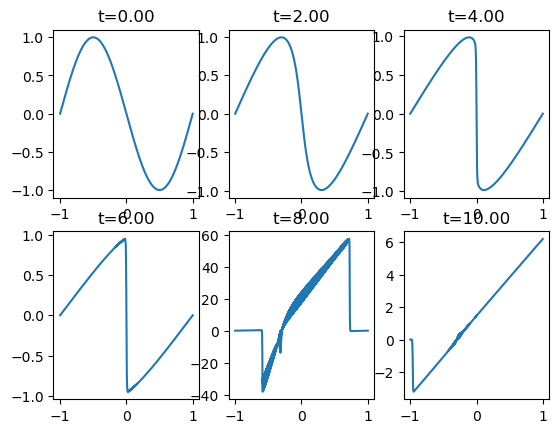

In [71]:
#create subplots
t_list = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
t_list = [int(t/dt) for t in t_list]

fig, axs = plt.subplots(2, 3)
for i, t in enumerate(t_list):
    axs[i//3, i%3].plot(x, u[t])
    axs[i//3, i%3].set_title(f"t={t*0.001:.2f}")


In [74]:
#save the data into a json file
import json
with open('testdata/burger_eqn.json','w') as f:
    json.dump({'x': x.tolist(), 'u': u.tolist()}, f)


In [75]:
#read from the json file
with open('testdata/burger_eqn.json','r') as f:
    data = json.load(f)
    x_new = jnp.array(data['x'])
    u_new = jnp.array(data['u'])


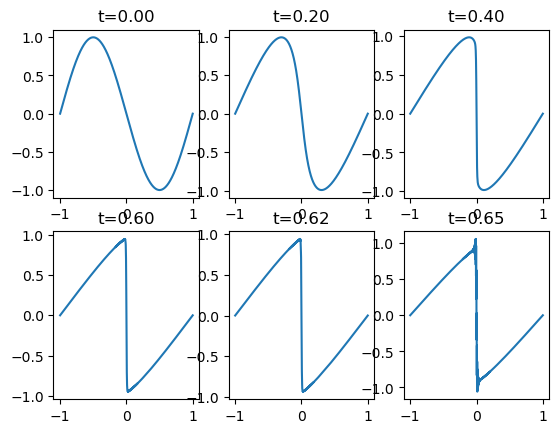

In [81]:
#create subplots
t_list = [0, 0.2, 0.4, 0.6, 0.62, 0.65]
t_list = [int(t/dt) for t in t_list]

fig, axs = plt.subplots(2, 3)
for i, t in enumerate(t_list):
    axs[i//3, i%3].plot(x_new, u_new[t])
    axs[i//3, i%3].set_title(f"t={t*0.001:.2f}")

In [84]:
# construct a non-stationary kernel

import tensorflow_probability.substrates.jax.bijectors as tfb
from gpjax.base import param_field

@dataclass
class NonstationaryKernel(gpx.kernels.AbstractKernel):
    variance: ScalarFloat = param_field(jnp.array(1.0), bijector=tfb.Softplus())
    variance_0: ScalarFloat = param_field(jnp.array(1.0), bijector=tfb.Softplus())

    def __call__(self, X1: Array, X2: Array, **params) -> Array:
        return 2/np.pi * jnp.arcsin(2*(self.variance_0 + self.variance* jnp.dot(X1, X2.T))/ jnp.sqrt(1+2*(self.variance_0 +self.variance*jnp.dot(X1, X1.T)) * (self.variance_0 +self.variance*jnp.dot(X2, X2.T))))
    

@dataclass
class BurgersKernel(gpx.kernels.AbstractKernel):
    Kernel_n_n: gpx.kernels.AbstractKernel = NonstationaryKernel()
    Kernel_n_n_1: gpx.kernels.AbstractKernel = NonstationaryKernel()
    Kernel_n_1_n_1: gpx.kernels.AbstractKernel = NonstationaryKernel()
    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"],
    **params) -> Float[Array, "1"]:
        dt = params['dt']
        Kernel_n_n = self.Kernel_n_n(X, Xp)
        # mu is the mean of x'
        mu = jnp.dot(X, Xp.T)
        # derivative of K with respect to x'
        dK_dx = jnp.gradient(Kernel_n_n, Xp)
        # second derivative of K with respect to x'
        d2K_dx2 = jnp.gradient(dK_dx, Xp)
        
        return self.Kernel_n_n(X, Xp) + self.Kernel_n_n_1(X, Xp) + self.Kernel_n_1_n_1(X, Xp)

    